# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required.

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories.


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [8]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import en_core_web_sm

from collections import Counter, defaultdict

nlp = en_core_web_sm.load()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# add any additional libaries you need here

import nltk
nltk.download('brown')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [10]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [11]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [12]:
categories = ['editorial','government','news','romance','hobbies']

category_list = []
file_ids = []
texts = []

for category in categories :
    for file_id in brown.fileids(categories=category) :

        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)

        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))



df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts

df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 3)

In [13]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='category'>

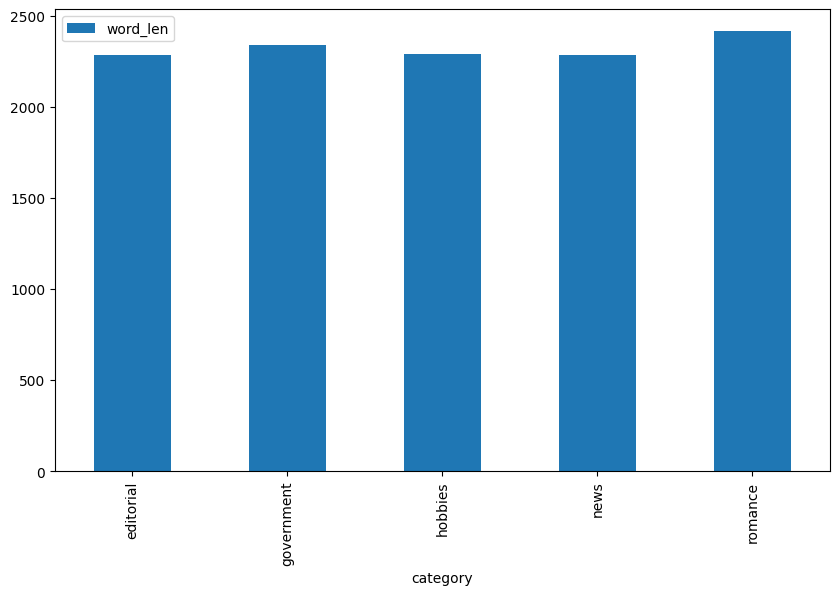

In [14]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [15]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [16]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold?

A: The first approach is coun vectorization where each word is assigned a unique integer ID converting the text documents into a matrix containing the word counts. The output shows that there are 166 documents in the brown corpus with 4,941 unique tokens fulfilling the frequency criteria. Now looking at term frequency-inverse document frequency (TD-IDF), this looks at the total frequency of a given term by the corpus by downscaling the importance of commonly found words. Similarly with the previuous shape count, the total words are 4,941 that meet the criteria within the 166 documents.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections.

In [17]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now some work for you to do. Compare the NMF categorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF categorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results.


In [19]:
# Your code here

# Tally the Brown categories for each topic in the NMF model
topic_categories = []

for topic_idx, topic in enumerate(H_text_matrix):
    topic_words = [tfidf_text_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]
    topic_words_str = ", ".join(topic_words)

    topic_categories_count = defaultdict(int)

    for idx, text_vector in enumerate(W_text_matrix):
        if np.argmax(text_vector) == topic_idx:
            category = df.iloc[idx]['category']
            topic_categories_count[category] += 1

    topic_categories.append((topic_idx, topic_words_str, dict(topic_categories_count)))

# Interpret the results
for topic_idx, topic_words, categories_count in topic_categories:
    print(f"\nTopic {topic_idx + 1}:")
    print(f"Top words: {topic_words}")
    print("Categories breakdown:")
    total_texts = sum(categories_count.values())
    for category, count in categories_count.items():
        percentage = (count / total_texts) * 100
        print(f" - {category}: {count} texts ({percentage:.2f}% of total texts in this topic)")


Topic 1:
Top words: mr, president, kennedy, united, khrushchev
Categories breakdown:
 - editorial: 20 texts (62.50% of total texts in this topic)
 - government: 4 texts (12.50% of total texts in this topic)
 - news: 8 texts (25.00% of total texts in this topic)

Topic 2:
Top words: said, didn, ll, thought, man
Categories breakdown:
 - editorial: 4 texts (9.76% of total texts in this topic)
 - romance: 29 texts (70.73% of total texts in this topic)
 - hobbies: 8 texts (19.51% of total texts in this topic)

Topic 3:
Top words: state, development, tax, sales, program
Categories breakdown:
 - editorial: 2 texts (3.08% of total texts in this topic)
 - government: 26 texts (40.00% of total texts in this topic)
 - news: 11 texts (16.92% of total texts in this topic)
 - hobbies: 26 texts (40.00% of total texts in this topic)

Topic 4:
Top words: mrs, mr, said, miss, car
Categories breakdown:
 - news: 17 texts (94.44% of total texts in this topic)
 - hobbies: 1 texts (5.56% of total texts in t

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: How does your five-topic NMF model compare to the original Brown categories?

A: After the top words were selected for each topic based on the TD-IDF, they were then compared to the prevalence found w/in each topic by tallying occurrence. The top words are then shown on the total texts of the original brown categories by showing the total percentage of that given topic. For example, the words mrs, mr, said, miss, and car were found in 17 news texts accounting for 94.44% of prevalence.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above.

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results.


In [20]:
# Your code here

## Fitting a TruncatedSVD (LSA) Model

# Fit a TruncatedSVD model
lsa_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)
H_lsa_matrix = lsa_model.components_

# Tally the Brown categories for each topic in the LSA model
lsa_topic_categories = []

for topic_idx, topic in enumerate(H_lsa_matrix):
    topic_words = [tfidf_text_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-6:-1]]
    topic_words_str = ", ".join(topic_words)

    topic_categories_count = defaultdict(int)

    for idx, text_vector in enumerate(W_lsa_matrix):
        if np.argmax(text_vector) == topic_idx:
            category = df.iloc[idx]['category']
            topic_categories_count[category] += 1

    lsa_topic_categories.append((topic_idx, topic_words_str, dict(topic_categories_count)))

# Interpret the results
for topic_idx, topic_words, categories_count in lsa_topic_categories:
    print(f"\nLSA Topic {topic_idx + 1}:")
    print(f"Top words: {topic_words}")
    print("Categories breakdown:")
    total_texts = sum(categories_count.values())
    for category, count in categories_count.items():
        percentage = (count / total_texts) * 100
        print(f" - {category}: {count} texts ({percentage:.2f}% of total texts in this topic)")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



LSA Topic 1:
Top words: said, mr, mrs, state, man
Categories breakdown:
 - editorial: 27 texts (18.24% of total texts in this topic)
 - government: 30 texts (20.27% of total texts in this topic)
 - news: 34 texts (22.97% of total texts in this topic)
 - romance: 21 texts (14.19% of total texts in this topic)
 - hobbies: 36 texts (24.32% of total texts in this topic)

LSA Topic 2:
Top words: said, ll, didn, thought, got
Categories breakdown:
 - romance: 8 texts (100.00% of total texts in this topic)

LSA Topic 3:
Top words: mrs, mr, said, kennedy, khrushchev
Categories breakdown:

LSA Topic 4:
Top words: mrs, club, game, jr, university
Categories breakdown:
 - news: 3 texts (100.00% of total texts in this topic)

LSA Topic 5:
Top words: game, league, baseball, ball, team
Categories breakdown:
 - news: 7 texts (100.00% of total texts in this topic)


Q: How does your five-topic LSA model compare to the original Brown categories?

A: The LSA model did have some differing outcomes from the non-negative matrix factorization model as the top words were predominately similar, and the categories breakdown differed with LSA topic 3 not providing an output to compare. In topic two, the LSA model accounted for a breakdown of only romance classification and none of hobbies or editorial. The same can be shown for LSA topic five.

In [21]:
# call display_topics on your model

display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output?

A: The output displays the top words among each topic alongside their weight displaying how strongly that word is associated with the corresponding topic. The breakdown can provide a slightly better understanding of the context used for each of the groups. The higher the number the more important that given word is in understanding that topic.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization.

In [22]:
# 1. Fit the LDA model
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(n_components=5, random_state=314)
lda_model.fit(count_text_vectors)

# 2. Get the topic-term distribution matrix from the LDA model
topic_term_dists = lda_model.components_

# 3. Get the document-topic distribution matrix from the LDA model
doc_topic_dists = lda_model.transform(count_text_vectors)

# 4. Get vocabulary and term frequency from the count vectorizer
vocab = count_text_vectorizer.get_feature_names_out()
term_frequency = np.ravel(count_text_vectors.sum(axis=0))  # Convert to 1-dimensional array

# Get the lengths of each document
doc_lengths = np.squeeze(np.asarray(count_text_vectors.sum(axis=1)))

# Display the topic-term distribution using pyLDAvis.display
pyLDAvis.display(pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab=vocab, term_frequency=term_frequency))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
# Call `display_topics` on your fitted model here

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

# Define the number of top words to display for each topic
no_top_words = 10

# Call the display_topics function on your fitted LDA model
display_topics(lda_model, vocab, no_top_words)

Topic 0:
said mrs little good way don ll old man thought

Topic 1:
state development 000 program business system sales small use 1960

Topic 2:
said mr president city state american john week home world

Topic 3:
feed college general university work president student students members schools

Topic 4:
states state united shall government tax fiscal department act class



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What inference do you draw from the displayed topics for your LDA model?

A: The initial inference is predominately on the usage of those specific terms and the context. For example, topic zero seems to display more of a conversational context while topic 1 is economically or business driven. Topic 2 is more politically focused while topic 3 revolves around education. Lastly, topic 4 appears to be a combination of both economical and political.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories?

A: I pasted the comparative code below to compare to the original brown categories and found that the categories did align with the perceived types.This output does show the category where the category were the words reside within and see if the context does match.

In [24]:
from collections import defaultdict

# Tally the Brown categories for each topic in the LDA model
topic_categories = []

for topic_idx, topic in enumerate(lda_model.components_):
    topic_words = [vocab[i] for i in topic.argsort()[:-6:-1]]
    topic_words_str = ", ".join(topic_words)

    topic_categories_count = defaultdict(int)

    for idx, text_vector in enumerate(doc_topic_dists):
        if np.argmax(text_vector) == topic_idx:
            category = df.iloc[idx]['category']
            topic_categories_count[category] += 1

    topic_categories.append((topic_idx, topic_words_str, dict(topic_categories_count)))

# Interpret the results
for topic_idx, topic_words, categories_count in topic_categories:
    print(f"\nTopic {topic_idx + 1}:")
    print(f"Top words: {topic_words}")
    print("Categories breakdown:")
    total_texts = sum(categories_count.values())
    for category, count in categories_count.items():
        percentage = (count / total_texts) * 100
        print(f" - {category}: {count} texts ({percentage:.2f}% of total texts in this topic)")


Topic 1:
Top words: said, mrs, little, good, way
Categories breakdown:
 - editorial: 3 texts (6.38% of total texts in this topic)
 - government: 1 texts (2.13% of total texts in this topic)
 - news: 4 texts (8.51% of total texts in this topic)
 - romance: 28 texts (59.57% of total texts in this topic)
 - hobbies: 11 texts (23.40% of total texts in this topic)

Topic 2:
Top words: state, development, 000, program, business
Categories breakdown:
 - editorial: 1 texts (4.00% of total texts in this topic)
 - government: 12 texts (48.00% of total texts in this topic)
 - news: 3 texts (12.00% of total texts in this topic)
 - hobbies: 9 texts (36.00% of total texts in this topic)

Topic 3:
Top words: said, mr, president, city, state
Categories breakdown:
 - editorial: 21 texts (35.59% of total texts in this topic)
 - government: 3 texts (5.08% of total texts in this topic)
 - news: 32 texts (54.24% of total texts in this topic)
 - romance: 1 texts (1.69% of total texts in this topic)
 - hobb

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
lda_display = pyLDAvis.lda_model.prepare(lda_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# 1. Get the topic-term distribution matrix from the LDA model
topic_term_dists = lda_model.components_

# 2. Display the topic-term distribution using pyLDAvis.display
lda_display = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab=vocab, term_frequency=term_frequency, sort_topics=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: First and foremost, I love the interactive format to visually display the data. The first aspect of the graph is the principal component scatterplot that displays the similarities between topics and the differences based on a two-dimensional space. It is evident that topic 1 and 3 are more distinctly unique compared to the other topics while 2 and 5 overlap. Topic 4 is similarly comparable to topics 2 and 5. The salient term graph does a great job displaying the top-30 most relative words based on the porportion of the corpus for each topic.
